# Objective

This is one of the most used ways of creating a recommendation system.

The way the model works is by finding some latent features of users and films and then multiplying them together.
The result should be intended as the model prediction for a given user on any given film.

The ideal matrix would probably look something like:

$$
\begin{bmatrix}
10  & 8 & 2 & 7 & 5\\
1 & 7 & 8 & 9 & 5\\
1 & 3 & 5 & 7 & 2\\
\end{bmatrix}
$$

Where the users are represented one for each row and on the columns we have the films.

However, this does not happen quite as frequently in real life as usually people rate very few movies, and the chance of finding different users who rated the same movie is not very high. 
This results in very sparse matrices where the $\text{No}$ means the user did not review the film:

$$
\begin{bmatrix}
10  & \text{No} & \text{No} & \text{No} & 1\\
\text{No} & \text{No} & 8 & \text{No} & \text{No}\\
\text{No} & \text{No} & 5 & 7 & 2\\
\end{bmatrix}
$$

Ideally, we want to reduce the sparsity as much as possible.
We can try to do this by always using all the movies rated by a user.

In [5]:
import torch as t
import random
import numpy as np

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using device: {device}")

# Reproducibility -> Also ensures same train / validation / test split every time
t.manual_seed(0)
random.seed(0)
np.random.seed(0)

using device: cuda


# Dataset

The dataset uses the file "rating_complete.csv" taken from https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020

A sample of the dataset is added to the git repository for quick tinkering.

The examples are going to be matrices of size $m$ rows and $n$ columns.

Alongside the matrix for a given index we are also going to provide a list of users (where the user at position $i$ is the rater of the $i$th row in the matrix) and a list of the anime ids which in turns is relative to the columns.
The model is supposed to learn anime features and user preferences all by itself.

In [22]:
from pandas import read_csv
from torch.utils.data import Dataset
from tqdm import tqdm
import itertools


class AnimeReviewsDataset(Dataset):
    def __init__(self, path, m, n, length) -> None:
        print(f"Reading csv from: {path}")
        self.users_to_rated_animes = { }
        self.user_anime_rating = { }
        self.users = set()
        self.animes = set()
        df = read_csv(path)
        print(f"Parsing Users preferences")
        for _, row in tqdm(df.iterrows()):
            user = row['user_id']
            anime = row['anime_id']
            rating = row['rating']
            self.users_to_rated_animes[user] = self.users_to_rated_animes.get(user, set()).union(set([anime]))
            self.user_anime_rating[(user,anime)] = rating.item()
            self.users.add(user)
            self.animes.add(anime)
        del df
        print(self.user_anime_rating)

        self.examples = []
        self.users = list(self.users)
        self.animes = list(self.animes)

        print(f"Generating small examples")
        for _ in tqdm(range(length)):
            sampled_users = random.choices(population=self.users, k = m)
            all_animes_seen_by_users = set()
            for user in sampled_users:
                all_animes_seen_by_users = all_animes_seen_by_users.union(self.users_to_rated_animes[user])
            sampled_animes = random.choices(population=list(all_animes_seen_by_users), k = n)
            matrix = []
            for i in range(m):
                matrix.append([])
                user = sampled_users[i]
                for j in range(n):
                    anime = sampled_animes[j]
                    matrix[i].append(self.user_anime_rating.get((user, anime), 0))
            
            self.examples.append((sampled_users, sampled_animes, matrix))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        return self.examples[index]


dataset = AnimeReviewsDataset("/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/rating_complete_short.csv", 10, 10, 100_000)

Reading csv from: /home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/rating_complete_short.csv
Parsing Users preferences


10000it [00:00, 68179.56it/s]


{(np.int64(30), np.int64(8074)): 8, (np.int64(67), np.int64(22663)): 7, (np.int64(74), np.int64(5081)): 9, (np.int64(83), np.int64(31904)): 5, (np.int64(134), np.int64(558)): 7, (np.int64(156), np.int64(2883)): 2, (np.int64(196), np.int64(4081)): 9, (np.int64(197), np.int64(13659)): 6, (np.int64(198), np.int64(34933)): 6, (np.int64(210), np.int64(16742)): 8, (np.int64(215), np.int64(30296)): 8, (np.int64(284), np.int64(33299)): 6, (np.int64(356), np.int64(384)): 7, (np.int64(362), np.int64(226)): 7, (np.int64(469), np.int64(38249)): 8, (np.int64(549), np.int64(16866)): 5, (np.int64(566), np.int64(36038)): 9, (np.int64(593), np.int64(34618)): 8, (np.int64(601), np.int64(12255)): 7, (np.int64(608), np.int64(13759)): 9, (np.int64(644), np.int64(8086)): 8, (np.int64(681), np.int64(226)): 8, (np.int64(694), np.int64(17080)): 9, (np.int64(694), np.int64(390)): 7, (np.int64(724), np.int64(5332)): 7, (np.int64(746), np.int64(29067)): 4, (np.int64(760), np.int64(11739)): 7, (np.int64(778), np.i

100%|██████████| 100000/100000 [00:02<00:00, 40547.83it/s]


In [24]:
users, animes, ratings = dataset.__getitem__(155)
ratings

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 8, 0, 0, 8],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 7, 0, 7, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 8, 0, 0, 0, 0, 0, 0, 7, 0],
 [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
 [9, 0, 0, 0, 0, 0, 0, 9, 0, 0]]

# Data distribution visualization

We now plot the data to see how the ratings are distributed

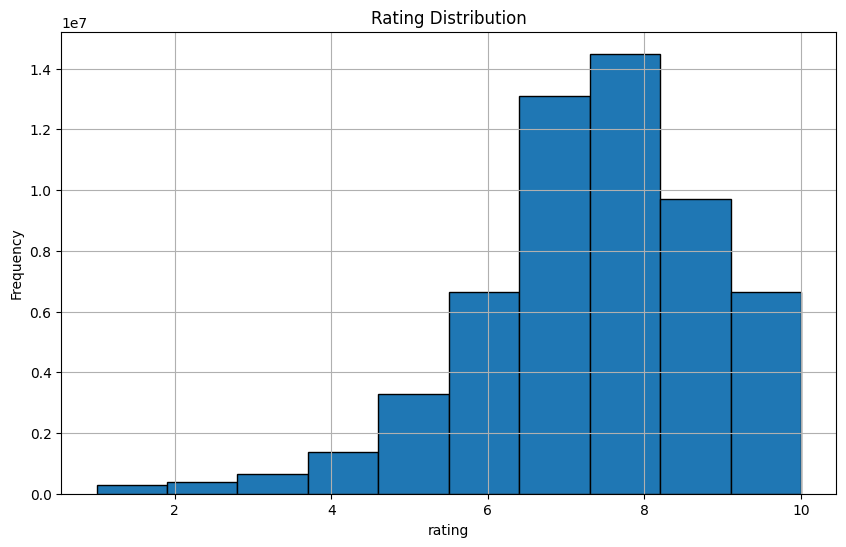

In [3]:
import matplotlib.pyplot as plt


x = dataset.ratings
plt.figure(figsize=(10,6))
plt.hist(x, bins=10, edgecolor='black') 
plt.title("Rating Distribution") 
plt.xlabel("rating") 
plt.ylabel("Frequency") 
plt.grid(True) 

# Separate the dataset

We split the dataset into training, test and validation

In [4]:
from torch.utils.data import random_split, DataLoader

batch_size = 2048

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(
    validation_dataset, shuffle=True, batch_size=batch_size
)

# Define a generic step

We perform this step regardless of the model, optimizer, or the phase we are in (training / test)

In [5]:
def run_step(model, loss_fn, features, genres, target):
    features = features.squeeze().to(device)
    target = target.squeeze().long().to(device)
    ones = t.ones(target.shape).long().to(device)
    target = t.sub(target, ones) # To go from ratings in [1:10] to values in [0:9]
    x = model(features, genres)
    loss = loss_fn(x, target)
    return loss, x

# The Model

Now it is time to build the model that predicts the value of a rating given the features

In [6]:
class MLP_Predictor(t.nn.Module):
    def __init__(self, types, emb_size, device, genres, ratings = 10, hidden_size = 4096) -> None:
        super().__init__()
        self.device = device
        self.embed = t.nn.Embedding(types, emb_size).to(device)
        self.genre_embedder = t.nn.Embedding(genres + 1, emb_size, padding_idx=dataset.PADDING_VALUE).to(device)
        self.sequential = t.nn.Sequential(
            # We expect 5 features + the type
            t.nn.LayerNorm(5 + emb_size * 2),
            t.nn.Linear(5 + emb_size * 2, hidden_size // 4),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 4),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 4, hidden_size // 2),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 2),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 2, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.LayerNorm(hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.BatchNorm1d(hidden_size),
            t.nn.Linear(hidden_size, ratings),
        ).to(device)


    def forward(self, x, genres):
        B, L = x.shape
        x.to(self.device)
        genres = genres.to(device)
        assert L == 6, "This predictor expects a 6-element feature vector"

        # Get the type (position 1 in the feature vector)
        ty = x[:, 1:2].long().squeeze()
        # Remove the type from x
        x = t.cat([x[:, :1], x[:, 2:]], dim=1)
        # Embed the type
        ty = self.embed(ty)
        x = t.cat([x, ty], dim=1)

        genres = self.genre_embedder(genres) # [B, G] -> [B, G, emb]
        genres = t.sum(genres, dim = 1) # [B, G, emb] -> [B, emb]

        x = t.cat([x, genres], dim=1)  # [B, L + emb_dim] cat [B, emb_dim]
        x = self.sequential(x)
        return x

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])

        return human_format(sum(p.numel() for p in self.parameters()))


model = MLP_Predictor(types=types, emb_size=10, device=device, genres=dataset.unique_genres, hidden_size=8192)
print(model.size())

310.65M


# First Steps

Here we check if everything is set up correctly

In [7]:
weight =t.Tensor([10,10,10,10,10,10,1,1,1,10]).to(device)
loss_fn = t.nn.CrossEntropyLoss() # Not using weight
learning_rate = 0.0001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
_, features, genres, target = next(iter(train_dataloader))
loss, logits = run_step(model, loss_fn, features, genres, target)
loss

tensor(2.4450, device='cuda:0', grad_fn=<NllLossBackward0>)

# Loading an existing model

It could be useful to start from where we left off.

In [8]:
import os


def get_unique_experiment_name():
    return model.__class__.__name__ + "_" + model.size()


models_dir = "/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/"
checkpoints = os.listdir(models_dir)
unique_name = get_unique_experiment_name()
checkpoints = [
    f for f in checkpoints if f[: min(len(unique_name), len(f))] == unique_name
]
if len(checkpoints) == 0:
    print("Starting from fresh: no models to load")
    epoch = 0
else:
    checkpoints.sort(key=lambda x: int(x[x.index("-") + 1 : -3]), reverse=True)

    epoch = int(checkpoints[0][checkpoints[0].index("-") + 1 : -3])
    print(f"Loading from {models_dir + checkpoints[0]}")
    model.load_state_dict(t.load(models_dir + checkpoints[0], weights_only=True))
    print(f"Loaded epoch {epoch}")

Loading from /home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/MLP_Predictor_310.65M_epoch-1.pt
Loaded epoch 1


# Training Loop

We set up a simple training loot that uses the validation and training sets to train the model

In [9]:
from tqdm import tqdm
from IPython.display import clear_output
import copy

train_losses = []
validation_losses = []

EVAL_EVERY = 10 # Only running evaluation step every 10 training steps

epochs = epoch + 2 # Set this to the number of training epochs you want to perform

with t.no_grad(): # To initialize the eval loss before training
    model.eval()
    _, fe, ge, ta = next(iter(validation_dataloader))
    loss, _ = run_step(model, loss_fn, fe, ge, ta)
    loss = loss.mean().item()
    best_eval_loss = loss
    best_epoch = -1
    model.train()

while epoch < epochs:
    current_train_loss = t.empty(0, device="cpu")
    current_eval_loss = t.empty(0, device="cpu")

    i = 0
    for user, features, genres, target in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss, _ = run_step(model, loss_fn, features, genres, target)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        current_train_loss = t.cat((current_train_loss, loss.to("cpu").unsqueeze(0)))

        if i == 0:
            #Validation Step
            with t.no_grad():
                model.eval()
                _, fe, ge, ta = next(iter(validation_dataloader))
                loss, _ = run_step(model, loss_fn, fe, ge, ta)
                loss = loss.mean()
                current_eval_loss = t.cat((current_eval_loss, loss.to("cpu").unsqueeze(0)))
                loss = loss.item()
                if loss < best_eval_loss: # Getting the best model
                    best_eval_loss = loss
                    best_model = copy.deepcopy(model)
                    best_epoch = epoch
                model.train()
        i = (i + 1) % EVAL_EVERY

    train_losses = train_losses + current_train_loss.tolist()
    validation_losses = validation_losses + current_eval_loss.tolist()
    
    clear_output()
    print(f"Finished epoch {epoch}")
    print(
        f"Training loss average = {sum(current_train_loss) / len(current_train_loss)}"
    )
    eval_loss = sum(current_eval_loss) / len(current_eval_loss)
    print(f"Evaluation loss average = {eval_loss}")
    print(f"Current Best Epoch: {best_epoch}: Validation Loss: {best_eval_loss}")
    epoch += 1

print(f"Going back to epoch {best_epoch}: validation loss: {best_eval_loss}")
model = best_model
epoch = best_epoch

Finished epoch 0
Training loss average = 1.7543095350265503
Evaluation loss average = 1.749603271484375
Current Best Epoch: 0: Validation Loss: 1.6871767044067383


  0%|          | 60/22084 [00:22<2:16:29,  2.69it/s]


KeyboardInterrupt: 

# Plotting the epochs

Using matplotlib to plot the result of the experiment

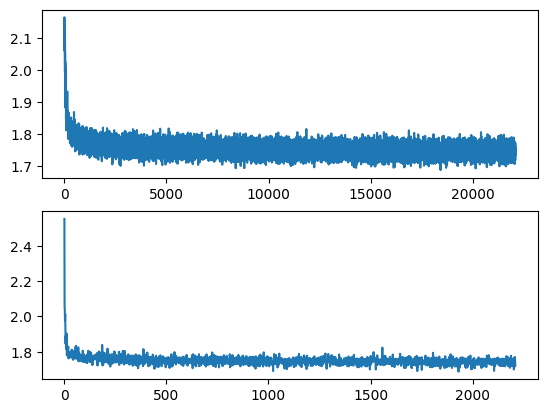

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

x = list(range(1, len(train_losses) + 1))
axs[0].plot(x, train_losses)


x = list(range(1, len(validation_losses) + 1))
axs[1].plot(x, validation_losses)
plt.show()

# Saving the model

As long as we are carrying out the same experiment we should be able to save and load the model.
This saves a lot of time and allows us to restart from where we left off the previous time.

In [11]:
t.save(
    model.state_dict(),
    f"/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/{get_unique_experiment_name()}_epoch-{epoch}.pt",
)

# Testing the model

We are going to calculate some metrics on the test set:

- First, we are going to calculate the loss on the test set
- Secondly, we consider the most likely value of the model to be the predicted value
- Then, we are going to perform a sampling from the tensor and get it as a prediction

In [ ]:
from sklearn.metrics import classification_report


test_losses = []
y_true = []
y_pred_map = []
y_pred_sampled = []
y_scores = []

with t.no_grad():
    model.eval()
    for _, features, ge, target in tqdm(test_dataloader):
        loss, logits = run_step(model, loss_fn, features, ge, target)
        loss = loss.item()
        test_losses.append(loss)

        target = target.long().squeeze().tolist()
        y_true = y_true + target

        # Get likeliest value for each element of the batch
        likeliest = t.argmax(logits, dim=1)
        likeliest = likeliest + t.ones(likeliest.shape).to(
            device
        )  # Going from [0, 9] back to [1 - 10]
        y_pred_map = y_pred_map + likeliest.squeeze().tolist()

        # Get top_k values
        logits = t.nn.functional.softmax(logits, dim=1)
        y_scores += logits.tolist()
        sampled = t.multinomial(logits, 1)
        sampled = sampled + t.ones(sampled.shape).to(
            device
        )  # Going from [0, 9] back to [1 - 10]
        sampled = sampled.squeeze().tolist()
        y_pred_sampled = y_pred_sampled + sampled


print(f"Average test loss: {sum(test_losses) / len(test_losses)}")
print(f"-------------------------")
print(f"Maximum A Posteriori Probability")
print(classification_report(y_true, y_pred_map))
print(f"-------------------------")
print(f"Results sampling from the model")
print(classification_report(y_true, y_pred_sampled))

100%|██████████| 2761/2761 [11:41<00:00,  3.94it/s]


Average test loss: 1.7416792466389188
-------------------------
Maximum A Posteriori Probability


/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           1       0.33      0.13      0.19     29141
           2       0.00      0.00      0.00     36762
           3       0.00      0.00      0.00     65022
           4       0.00      0.00      0.00    138175
           5       0.21      0.05      0.08    328783
           6       0.24      0.08      0.12    664364
           7       0.29      0.51      0.37   1307516
           8       0.31      0.49      0.38   1448489
           9       0.31      0.21      0.25    970337
          10       0.46      0.07      0.12    664870

    accuracy                           0.30   5653459
   macro avg       0.22      0.15      0.15   5653459
weighted avg       0.30      0.30      0.26   5653459

-------------------------
Results sampling from the model
              precision    recall  f1-score   support

           1       0.06      0.08      0.07     29141
           2       0.03      0.03      0.03     36762
           3       0

# Further Testing

Plotting the ROC plot we can see how the model is deviating from the pure chance.

Besides, we compute the micro-average AUC to see how the model is performing.

The **micro-average is preferable** in this case because the classes are not equally distributed.

Lastly, we compute the top@K Accuracy because we want to count how many times the rating appears in the top $k$ ratings predicted by the model.

One Hot encoded the test set: (5653459, 10)
One Hot Example #0: [0 0 0 0 0 0 0 0 0 1]

Logits given by the model: (5653459, 10)
Logits of Example #0: [0.0011011  0.00132204 0.00190077 0.00402346 0.01527424 0.02977295
 0.10451847 0.21329387 0.33122754 0.29756555]
Micro-averaged One-vs-Rest ROC AUC score: 0.81
TOP - K accuracy score: 0.723191058783658


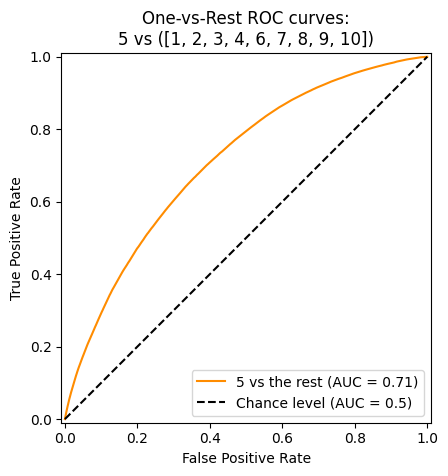

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, top_k_accuracy_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.metrics import roc_auc_score

rating_of_interest = 5
assert 0 < rating_of_interest <= 10, "The rating should be in range [1 - 10]"

label_binarizer = LabelBinarizer().fit(y_true) # One Hot encoding (sklearn style) 
y_one_hot = label_binarizer.transform(y_true) # Label binarizer takes care of the fact that y_true has range [1-10] while logits at position i contain the probability of the rating i + 1

logits = np.array(y_scores).squeeze()


print(f"One Hot encoded the test set: {y_one_hot.shape}")
print(f"One Hot Example #0: {y_one_hot[0]}")
print()
print(f"Logits given by the model: {logits.shape}")
print(f"Logits of Example #0: {logits[0]}")



# Plotting the ROC plot
display = RocCurveDisplay.from_predictions(
    y_one_hot[:, rating_of_interest - 1],
    logits[:, rating_of_interest - 1],
    name=f"{rating_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"One-vs-Rest ROC curves:\n{rating_of_interest} vs ({[i for i in range(1, 11) if i != rating_of_interest]})",
)

# Calculating AUC with micro average
micro_roc_auc_ovr = roc_auc_score(
    y_one_hot,
    logits,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr:.2f}")


#Calculating the top k accuracy of the model
K = 3
tk_acc = top_k_accuracy_score(y_true, logits, k=K)
print(f"TOP - K accuracy score: {tk_acc}")
